## Importing dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Part 1 - Import and clean data
## Import the data

In [2]:
source_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" #As given in the assignment

raw_page = pd.read_html(source_url)

toronto_data_raw = raw_page[0] #The 1st table from the raw page
print("Raw data shape",toronto_data_raw.shape)
toronto_data_raw.head(10)

Raw data shape (180, 3)


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


## Clean the dataframe

In [3]:
#Remove not assigned boroughs
toronto_data = toronto_data_raw[toronto_data_raw['Borough'] != 'Not assigned'].reset_index(drop=True)

print("Data shape",toronto_data.shape)
toronto_data.head(10)

Data shape (103, 3)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
#Replace not assigned neighbohoods with the borough's name
changes = 0

for index, row in toronto_data.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']
        changes = changes + 1


print(changes, "changes were made")
toronto_data.head(10)

0 changes were made


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [13]:
#As there are neighborhoods with more than one postal code, we'll leave only one
toronto_data = toronto_data.drop_duplicates(subset=['Neighborhood'], keep=False)
toronto_data.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [15]:
print("Clean data shape",toronto_data.shape)

Clean data shape (97, 3)


# Part 2 - Add Location Data

In [16]:
# Using the code to fetch coordinates from the csv file as published in the assignment
file_name = "Geospatial_Coordinates.csv"
postal_codes_coord = pd.read_csv(file_name)
postal_codes_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### As column names are the same we'll just merge the 2 dataframes

In [17]:
toronto_data = pd.merge(toronto_data, postal_codes_coord, on='Postal Code', how='inner')
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## We'll use only boroughs with the word 'Toronto'

In [18]:
toronto_data = toronto_data[~toronto_data.Borough.str.contains("Toronto")]
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353


In [19]:
toronto_data.shape

(58, 5)

# Part 3 - Explore and Cluster

### Use geopy library to get the latitude and longitude values of Toronto

In [20]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with neighborhoods superimposed on top.

In [21]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

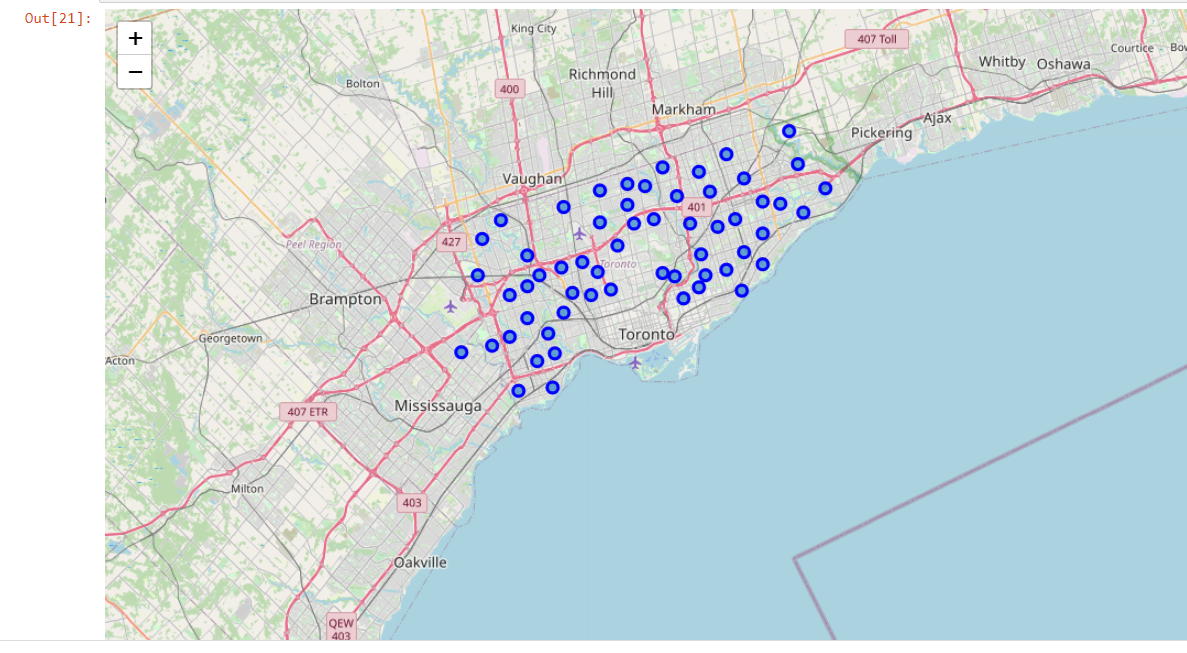

## Define Foursquare Credentials and Version
CLIENT_ID and CLIENT_SECRET were obfuscated

In [ ]:
CLIENT_ID = 'xxxx' # Removed before shared publicly
CLIENT_SECRET = '????' # Removed before shared publicly
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if results == []:
            print("---\n No venues found for", name,"\n---")
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### And now let's create the venues for Toronto

In [51]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head()

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Islington Avenue, Humber Valley Village
---
 No venues found for Islington Avenue, Humber Valley Village 
---
Malvern, Rouge
Parkview Hill, Woodbine Gardens
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
---
 No venues found for West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale 
---
Rouge Hill, Port Union, Highland Creek
Woodbine Heights
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
Caledonia-Fairbanks
Woburn
Leaside
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Golden Mile, Clairlea, Oakridge
York Mills, Silver Hills
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Cli

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [45]:
toronto_venues.to_csv(r'toronto_venues.csv',index=False)

In [52]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 138 uniques categories.


### Analyze Each Neighborhood

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Drugstore,Electronics Store,Event Space,Farm,Fast Food Restaurant,Field,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Hardware Store,Hobby Shop,Hockey Arena,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
toronto_onehot.shape

(467, 139)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [55]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Store,Bike Shop,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Drugstore,Electronics Store,Event Space,Farm,Fast Food Restaurant,Field,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Hardware Store,Hobby Shop,Hockey Arena,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Soccer Field,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.125000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.125000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125,0.0

#### Let's print each neighborhood along with the top 5 most common venues

In [57]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2               Skating Rink   0.2
3             Clothing Store   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Gym  0.12
2             Pub  0.12
3     Coffee Shop  0.12
4  Sandwich Place  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
           venue  freq
0           Bank  0.10
1    Coffee Shop  0.10
2  Deli / Bodega  0.05
3    Bridal Shop  0.05
4      Gift Shop  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1  Japanese Restaurant  0.25
2                 Café  0.25
3                 Bank  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.09
1          Restaurant  0.09
2         Coffee Shop  0.09
3      Sandwich Place  0.09
4              

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [133]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Skating Rink,Breakfast Spot,Latin American Restaurant,Clothing Store,Lounge
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Pool
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Sushi Restaurant,Middle Eastern Restaurant
3,Bayview Village,Bank,Japanese Restaurant,Café,Chinese Restaurant,Field
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Restaurant,Hobby Shop


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [134]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [136]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_merged with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = pd.merge(toronto_merged, neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Construction & Landscaping,Food & Drink Shop,Park,Yoga Studio,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Pizza Place,Portuguese Restaurant,Coffee Shop,Intersection,Hockey Arena
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Event Space
3,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Yoga Studio,Drugstore,Fish & Chips Shop,Field
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2,Pizza Place,Bank,Pet Store,Fast Food Restaurant,Pharmacy


Finally, let's visualize the resulting clusters

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

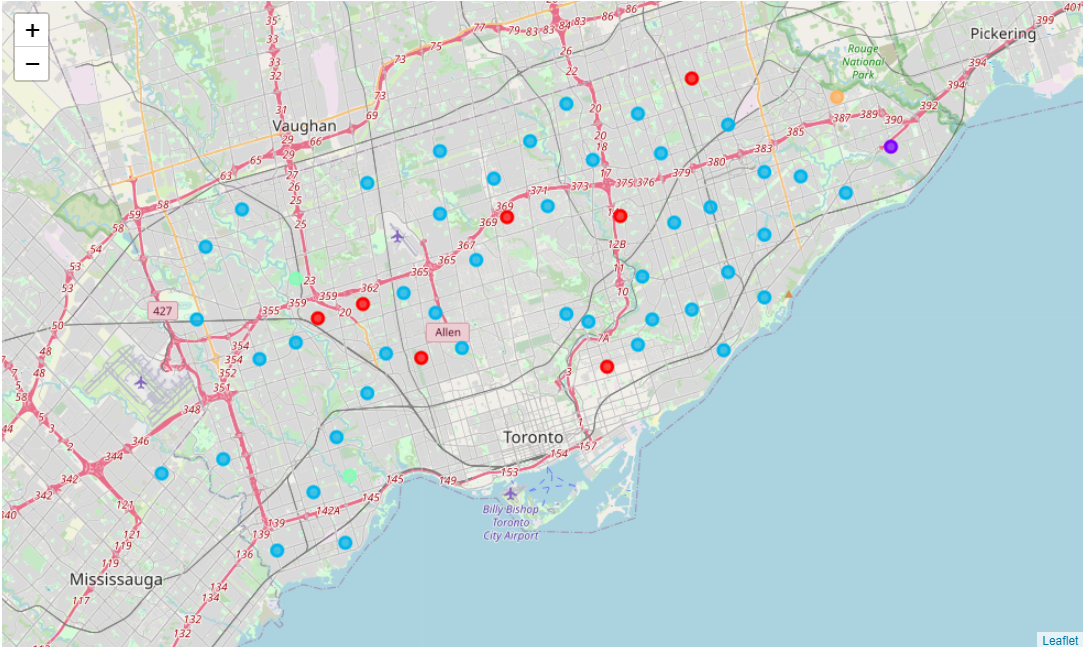

## Examine Clusters

In [ ]:
### Cluster 1

In [138]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,0,Construction & Landscaping,Food & Drink Shop,Park,Yoga Studio,Dog Run
11,York,0,Park,Women's Store,Bakery,Drugstore,Fish & Chips Shop
21,East York,0,Park,Convenience Store,Dog Run,Field,Fast Food Restaurant
26,North York,0,Construction & Landscaping,Park,Bakery,Basketball Court,Yoga Studio
35,York,0,Park,Yoga Studio,Dog Run,Field,Fast Food Restaurant
37,North York,0,Convenience Store,Park,Dog Run,Field,Fast Food Restaurant
45,Scarborough,0,Playground,Park,Distribution Center,Fast Food Restaurant,Farm


### Cluster 2

In [139]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Scarborough,1,Bar,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Field


### Cluster 3

In [140]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,North York,2,Pizza Place,Portuguese Restaurant,Coffee Shop,Intersection,Hockey Arena
2,North York,2,Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Event Space
4,East York,2,Pizza Place,Bank,Pet Store,Fast Food Restaurant,Pharmacy
5,North York,2,Japanese Restaurant,Asian Restaurant,Pub,Bakery,Italian Restaurant
7,East York,2,Curling Ice,Athletics & Sports,Skating Rink,Beer Store,Pharmacy
8,York,2,Playground,Trail,Field,Hockey Arena,Curling Ice
9,Etobicoke,2,Convenience Store,Beer Store,Pharmacy,Pizza Place,Coffee Shop
10,Scarborough,2,Intersection,Breakfast Spot,Medical Center,Electronics Store,Rental Car Location
12,Scarborough,2,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Field
13,East York,2,Coffee Shop,Bank,Burger Joint,Furniture / Home Store,Sporting Goods Shop


### Cluster 4

In [141]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,North York,3,Baseball Field,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Field
52,Etobicoke,3,Baseball Field,Yoga Studio,Food & Drink Shop,Fish & Chips Shop,Field


### Cluster 5

In [142]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Scarborough,4,Fast Food Restaurant,Yoga Studio,Drugstore,Fish & Chips Shop,Field
